In [1]:
# unwrap archive cache file
archive_wandb_cache_file = 'wandb_cost_df_cache.pkl.gz'

import gzip

# ungzip the file
with gzip.open(archive_wandb_cache_file, 'rb') as f:
    with open('wandb_cost_df_cache.pkl', 'wb') as f2:
        f2.write(f.read())

In [2]:
import os

import wandb
from collections import defaultdict

api = wandb.Api()

datasets = ['airline', 'imdb', 'ssb', 'tpc_h', 'walmart', 'financial', 'basketball', 'accidents', 'movielens',
            'baseball', 'hepatitis', 'tournament', 'genome', 'credit', 'employee', 'carcinogenesis', 'consumer',
            'geneea', 'seznam', 'fhnk']


wandb_project = 'jwehrstein/udf_cost_estimation'

def get_table_df(url: str, label: str):
    artifact = api.artifact(url)
    artifact.download()
    table = artifact.get(label)
    return table.get_dataframe()


def extract_dataset_from_name(name: str):
    candidates = []
    for dataset in datasets:
        if f'_{dataset}_' in name:
            candidates.append(dataset)

    assert len(candidates) == 1, f'Found {len(candidates)} candidates for {name}'
    return candidates[0]


wandb_cache_file = 'wandb_cost_df_cache.pkl'
if os.path.exists(wandb_cache_file):
    import pickle

    with open(wandb_cache_file, 'rb') as f:
        df_cache = pickle.load(f)
else:
    df_cache = dict()


def get_dataframes_from_run(run: str):
    
    if run in df_cache:
        print(f'Found run {run} in cache')
        return df_cache[run]

    df_dict = defaultdict(dict)

    instance = api.run(f'{wandb_project}/{run}')
    dataset = extract_dataset_from_name(instance.displayName)

    if wandb.run is None:
        wandb.init()

    for test_file in ['workload', 'workload_no_udf', 'workload_pullup']:
        for card in ['act', 'est', 'dd', 'wj']:
            test_file_lookup = test_file
            if test_file_lookup == 'workload' and f'{test_file_lookup}_{card}' not in instance.summary.keys():
                test_file_lookup = 'workload_pushdown'

            if f'{test_file_lookup}_{card}' not in instance.summary.keys():

                print(f'Artifact {test_file_lookup}_{card} not found in run {run} (dataset: {dataset})')
                continue

            artifact_url = f'{wandb_project}/run-{run}-{test_file_lookup}_{card}test_{test_file_lookup}_{card}_data:latest'
            df_dict[test_file][card] = get_table_df(artifact_url, f'{test_file_lookup}_{card}.test_{test_file_lookup}_{card}_data')

    df_cache[run] = dataset, df_dict

    # save cache to file
    import pickle
    with open(wandb_cache_file, 'wb') as f:
        pickle.dump(df_cache, f)

    return dataset, df_dict

In [3]:
from models.training.metrics import QError
import pandas as pd

runs = [
    # wandb-run-id, string
    ('ucbei12z','(1)'), #RET nodes only
    ('vbl8qe5k', '(2)'), #+ LOOP, COMP,\nBRANCH
    ('llan34e8','(3)'),  #+ FILTER: on-udf\nfeature
    ('x2xp5osz','(4)'), # + LOOP_END
    ('75w6y3ke','(5)'), # + LOOP_START\n->END edge
]

# initialize dictionaries
run_dict = defaultdict(dict)
for i, r in enumerate(runs):
    print(f'Processing run {r}: {i + 1}/{len(runs)}')
    try:
        dataset, run_data = get_dataframes_from_run(r[0])
    except Exception as e:
        print(e)
        continue

    run_dict[dataset][r[1]] = run_data
    
def combine_dataframes_by_dataset_card_and_run(run_dict, include_no_udf: bool = False):
    df_dataset_run_dict = defaultdict(dict)
    
    for dataset, runs in run_dict.items():
        for run, run_data in runs.items():
            for test_file, card_dict in run_data.items():
                if not include_no_udf and ('no_udf' in test_file or 'noudf' in test_file):
                    # skip no_udf dataframes
                    continue
    
                for card, df in card_dict.items():
                    if card not in df_dataset_run_dict[dataset]:
                        df_dataset_run_dict[dataset][card] = dict()
                    if run not in df_dataset_run_dict[dataset][card]:
                        df_dataset_run_dict[dataset][card][run] = []
                    df_dataset_run_dict[dataset][card][run].append((test_file,df))
    
    for dataset, runs in df_dataset_run_dict.items():
        for card, df_dict in runs.items():
            for run, df_list in df_dict.items():
                # make sure that 80/10/10 split is kept for each dataset - necessary for equal comparison of all databases
                df_dict = dict()
                num_pushdown = 0
                num_pullup = 0
                num_noudf = 0
                for test_file, df in df_list:
                    if 'no_udf' in test_file or 'noudf' in test_file:
                        assert False, 'No UDF dataframes should not be included'
                        assert 'noudf' not in df_dict
                        df_dict['noudf'] = df
                        num_noudf = len(df)
                    elif 'pullup' in test_file:
                        assert 'pullup' not in df_dict
                        df_dict['pullup'] = df
                        num_pullup = len(df)
                    else:
                        assert 'pushdown' not in df_dict
                        df_dict['pushdown'] = df
                        num_pushdown = len(df)
    
                threshold = 5
                if num_pullup > threshold * num_pushdown:
                    # pick plans randomly
                    print(f'Picking {threshold} of pullup plans for {dataset} (card: {card}) ({num_pullup/num_pushdown if num_pushdown>0 else 0:.2f})')
                    df_dict['pullup'] = df_dict['pullup'].sample(int(threshold * num_pushdown))
                if num_noudf > 0.15 * num_pushdown:
                    # pick plans randomly
                    print(f'Picking {threshold} of no_udf plans for {dataset} (card: {card}) ({num_noudf/num_pushdown if num_pushdown>0 else 0 :.2f})')
                    df_dict['noudf'] = df_dict['noudf'].sample(int(threshold * num_pushdown))
    
                df_list = list(df_dict.values())
                # df_list = [df for _, df in df_list]
                
                df_dataset_run_dict[dataset][card][run] = pd.concat(df_list)

    return df_dataset_run_dict


df_runs_dict = combine_dataframes_by_dataset_card_and_run(run_dict)
# compute the qerror for each slice
metrics = [
    QError(percentile=50,verbose=False), 
    QError(percentile=95,verbose=False), 
    QError(percentile=99,verbose=False),
       # QError(percentile=100,verbose=False)
]

Processing run ('ucbei12z', '(1)'): 1/5
Found run ucbei12z in cache
Processing run ('vbl8qe5k', '(2)'): 2/5
Found run vbl8qe5k in cache
Processing run ('llan34e8', '(3)'): 3/5
Found run llan34e8 in cache
Processing run ('x2xp5osz', '(4)'): 4/5
Found run x2xp5osz in cache
Processing run ('75w6y3ke', '(5)'): 5/5
Found run 75w6y3ke in cache


In [4]:
from ipywidgets import interact
from collections import defaultdict
import tabulate
import numpy as np
import matplotlib.pyplot as plt

# ensure type1 fonts - for camera ready submission
plt.rcParams.update({"pdf.fonttype": 42,"ps.fonttype": 42})

@interact(dataset=df_runs_dict.keys(), card=['act', 'est', 'dd', 'wj'], min_num_loops=[0,1,2,3], max_num_loops=[None,0,1,2,3], min_num_branches=[0,1,2,3], max_num_branches=[None,0,1,2,3])
def plot(dataset:str, card:str, min_num_loops:int, max_num_loops:int, min_num_branches:int, max_num_branches:int, return_fig=False):
    # create barplot with both lists
    plt.close()
    fig, axs = plt.subplots(1,len(metrics), figsize=(7, 2.5))
    
    error_dict = dict()
    num_entries_dict = dict()
    
    for run,df in df_runs_dict[dataset][card].items():
        if len(df)==0:
            print(f'Empty dataframe for {card} card and {dataset} dataset')
            continue
        assert len(df)>0, f'Empty dataframe for {card} card and {dataset} dataset'
        
        # filter df by number of loops
        df = df[df['udf_num_loops'] >= min_num_loops]
        if max_num_loops is not None and max_num_loops>=min_num_loops:
            df = df[df['udf_num_loops'] <= max_num_loops]
            
        # filter df by number of branches
        df = df[df['udf_num_branches'] >= min_num_branches]
        if max_num_branches is not None and max_num_branches>=min_num_branches:
            df = df[df['udf_num_branches'] <= max_num_branches]
        
        per_run_errors = dict()
    
        for metric in metrics:
            
            error = metric.evaluate_metric(df['label'], df['pred'])
            per_run_errors[metric.name] = error
    
        error_dict[run] = per_run_errors
        num_entries_dict[run] = len(df)
    
    run_list = list(error_dict.keys())
    
    x = np.arange(len(run_list))
    
    assert len(set(num_entries_dict.values())) == 1, 'Number of entries is not the same for all runs'
    num_queries = list(num_entries_dict.values())[0]
    print(f'Number of queries: {num_queries}')
    
    metrics_dict = {
        'QError(median)': 'Median',
        'QError(95th percentile)': '95th percentile',
        'QError(99th percentile)': '99th percentile',
        'QError(max)': 'Max'
    }
    
    for axs_id,metric in enumerate(metrics):
        metric_name = metric.name
    
        ax = axs[axs_id]
        
        ax.bar(x, [error_dict[run][metric_name] for run in run_list], label=card, color='darkturquoise')
        
        
        ax.margins(y=0.5)
    
        # ax.set_xlabel(f'Configuration')
        # ax.set_ylabel(f'{metric.name}')
        # ax.set_ylabel(metrics_dict[metric.name])
    
        ax.set_xticks(np.arange(len(run_list)))
        ax.set_xticklabels(run_list, rotation=0, ha='center')
    
        # set title
        ax.set_title(metrics_dict[metric.name])
    
        max_vals = {
            'QError(median)': 4,
            'QError(95th percentile)': 100,
            'QError(99th percentile)': 300,
            'QError(max)': 500
        }
    
        errors = [per_run_errors[metric_name] for run, per_run_errors in error_dict.items()]
        errors = [e for e in errors if not np.isnan(e)]
        ax.set_ylim(1, min(max_vals[metric.name] if metric.name in max_vals else np.inf,
                           max(errors) * 1.1))
    
        # place legend below chart
        # ax.legend(ncol=1)
        
        if axs_id == 0:
            fmt = '%.2f'
        elif axs_id ==1:
            fmt = '%.1f'
        else:
            fmt = '%.0f'
    
        ax.bar_label(ax.containers[0],label_type='edge', fmt=fmt)
        
        
        # labels which are larger than the max value draw manually
        for i, error in enumerate([error_dict[run][metric_name] for run in run_list]):
            if error > ax.get_ylim()[1]:
                if axs_id == 0:
                    ax.text(i, ax.get_ylim()[1] * 0.97, f'{error:.2f}', ha='center', va='top')
                elif error < 100:
                    ax.text(i, ax.get_ylim()[1] * 0.97, f'{error:.1f}', ha='center', va='top')
                else:
                    ax.text(i, ax.get_ylim()[1] * 0.97, f'{error:.0f}', ha='center', va='top')
    
    # add space between subplots
    plt.tight_layout()
    
    plt.show()
    
    # create a horizontal median plot as well
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))
    
    ablation_lookup = {
        '(1)': 'RET nodes only (1)',
        '(2)': '+ LOOP, COMP, BRANCH (2)',
        '(3)': '+ FILTER: on-udf feature (3)',
        '(4)': '+ LOOP_END (4)',
        '(5)': '+ residual LOOP edge (5)',
        '(6)': 'Sep. UDF and SQL cost est. (6)',
    }
    
    # reverse run_list
    run_list = list(reversed(run_list))
    
    # Create horizontal bar chart for the median metric
    median_errors = [error_dict[run]['QError(median)'] for run in run_list]
    ax.barh([ablation_lookup[r] for r in run_list], median_errors, color='darkturquoise')
    
    ax.set_xlim(1, max(median_errors)*1.1)
    ax.set_xlabel('QError(median)')
    # ax.set_title('Median QError by Run')
    
    # Add labels to the bars
    for i, error in enumerate(median_errors):
        ax.text(error+0.015, i, f'{error:.2f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    tabulate_data = []
    for run in run_list:
        row_data = [card]
        for metric in metrics:
            metric_name = metric.name
            
            error = error_dict[run][metric_name]
            row_data.append(error)
        
        tabulate_data.append(row_data)
    
    print(f'QError statistics ({dataset}, {card} card)')
    print(tabulate.tabulate(tabulate_data, headers=['Card']+[m.name for m in metrics]))
    
    if return_fig:
        return fig

interactive(children=(Dropdown(description='dataset', options=('genome',), value='genome'), Dropdown(descripti…

Number of queries: 1739


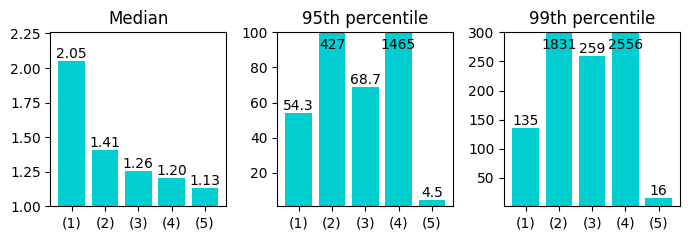

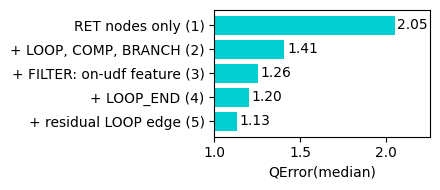

QError statistics (genome, act card)
Card      QError(median)    QError(95th percentile)    QError(99th percentile)
------  ----------------  -------------------------  -------------------------
act              1.13389                    4.50467                     15.907
act              1.20142                 1465.21                      2555.72
act              1.25606                   68.7229                     259.497
act              1.40905                  426.616                     1830.84
act              2.05309                   54.2535                     134.925


In [7]:
fig = plot('genome', 'act', 0, None, 0, None,return_fig=True)
fig.savefig('results/feature_ablation.pdf', bbox_inches='tight')

In [6]:
import pandas as pd

df = df_runs_dict['genome']['est']['(5)']

# compute qerror for each element
qerrors = np.maximum(df['label']/df['pred'], df['pred']/df['label']).to_numpy()
arg_max = np.argmax(qerrors)

print(f'Maximum qerror: {qerrors[arg_max]}',flush=True)

# get the query with the maximum qerror
query = df.iloc[arg_max]
print(query['sql'])
print(query)

Maximum qerror: 49378.70310594518
SELECT * FROM (SELECT * FROM "IMG_REL" JOIN "IMG_OBJ" ON "IMG_REL"."IMG_ID" = "IMG_OBJ"."IMG_ID" JOIN "IMG_OBJ_ATT" ON "IMG_OBJ"."IMG_ID" = "IMG_OBJ_ATT"."IMG_ID"  WHERE "IMG_OBJ"."H" <= -131) as nested_query WHERE func_160(nested_query."OBJ1_SAMPLE_ID") <= 7;
label                                                               0.205169
pred                                                            10130.979492
sample_idxs                                                                4
sql                        SELECT * FROM (SELECT * FROM "IMG_REL" JOIN "I...
num_joins                                                                  2
num_filters                                                                1
udf_num_np_calls                                                           0
udf_num_math_calls                                                         2
udf_num_comp_nodes                                                         9
udf_num_bran